In [1]:
import numpy as np
import cv2
import os
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [2]:
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path, split=0.3):
    images = sorted(glob(os.path.join(path, "seg_images", "*.jpg")))
    masks = sorted(glob(os.path.join(path, "seg_masks", "*.jpg")))

    if len(images) == 0 or len(masks) == 0:
        raise ValueError("No images or masks found in the specified path.")

    if len(images) != len(masks):
        raise ValueError("Number of images and masks do not match.")

    train_x, test_x, train_y, test_y = train_test_split(images, masks, test_size=split, random_state=42)

    return (train_x, train_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset


np.random.seed(42)
tf.random.set_seed(42)

""" Directory for storing files """
create_dir("files")

""" Hyperparameters """
batch_size = 16
lr = 1e-4
num_epochs = 300
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "log.csv")

""" Dataset """
dataset_path = "/kaggle/input/segmentation/Segmentation Dataset"
(train_x, train_y), (test_x, test_y) = load_dataset(dataset_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Test : {len(test_x)} - {len(test_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(test_x, test_y, batch=batch_size)

Train: 49 - 49
Test : 21 - 21


In [3]:
patch_size = 4

def convo_block(x, filters, kernel_size=3, strides=2):
    conv_layer = tf.keras.layers.Conv2D(
        filters, kernel_size, strides=strides, activation=tf.nn.swish, padding="same"
    )
    return conv_layer(x)

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.nn.swish)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

def transformer_block(x, transformer_layers, projection_dim, num_heads=2):
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer.
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = tf.keras.layers.Add()([attention_output, x])
        # Layer normalization 2.
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=[x.shape[-1] * 2, x.shape[-1]], dropout_rate=0.1,)
        # Skip connection 2.
        x = tf.keras.layers.Add()([x3, x2])

    return x


def vit_block(x, num_blocks, projection_dim, strides=1):
    # # Local projection with convolutions.
    local_features = convo_block(x, filters=projection_dim, strides=strides)

    # Unfold into patches and then pass through Transformers.
    num_patches = int((local_features.shape[1] * local_features.shape[2]) / patch_size)
    non_overlapping_patches = tf.keras.layers.Reshape((patch_size, num_patches, projection_dim))(
        local_features
    )
    global_features = transformer_block(
        non_overlapping_patches, num_blocks, projection_dim
    )

    # Fold into conv-like feature-maps.
    folded_feature_map = tf.keras.layers.Reshape((*local_features.shape[1:-1], projection_dim))(
        global_features
    )

    # Fuse the local and global features using a convoluion layer.
    local_global_features = convo_block(
        folded_feature_map, filters=projection_dim, strides=strides
    )

    return local_global_features

In [4]:
input_shape = (256, 256, 3)

def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)


    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    v1 = vit_block(d1, num_blocks=1, projection_dim=64)
    d2 = decoder_block(v1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = tf.keras.models.Model(inputs, outputs, name="AB-CAPNET")
    return model


model = build_unet(input_shape)
model.summary()

Model: "AB-CAPNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
__________________________________________________________________________________________

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [6]:
model = build_unet((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=False),
]

history3=model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/300
4/4 [==============================] - 20s 2s/step - loss: 0.9788 - dice_coef: 0.0192 - val_loss: 0.9796 - val_dice_coef: 0.0211

Epoch 00001: val_loss improved from inf to 0.97960, saving model to files/model.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/300
4/4 [==============================] - 6s 2s/step - loss: 0.9742 - dice_coef: 0.0243 - val_loss: 0.9796 - val_dice_coef: 0.0211

Epoch 00002: val_loss improved from 0.97960 to 0.97958, saving model to files/model.h5
Epoch 3/300
4/4 [==============================] - 6s 2s/step - loss: 0.9710 - dice_coef: 0.0279 - val_loss: 0.9796 - val_dice_coef: 0.0211

Epoch 00003: val_loss improved from 0.97958 to 0.97957, saving model to files/model.h5
Epoch 4/300
4/4 [==============================] - 6s 2s/step - loss: 0.9671 - dice_coef: 0.0318 - val_loss: 0.9796 - val_dice_coef: 0.0211

Epoch 00004: val_loss improved from 0.97957 to 0.97956, saving model to files/model.h5
Epoch 5/300
4/4 [==============================] - 6s 2s/step - loss: 0.9611 - dice_coef: 0.0376 - val_loss: 0.9796 - val_dice_coef: 0.0211

Epoch 00005: val_loss did not improve from 0.97956
Epoch 6/300
4/4 [==============================] - 6s 2s/step - loss: 0.9532 - dice_coef: 0.0452 - val_loss: 0.9796 - val_di

In [8]:
import cv2
import numpy as np

def predict_mask(model, image_path):
    # Read and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256)) / 255.0
    img = np.expand_dims(img, axis=0)

    # Perform prediction
    mask = model.predict(img)

    return mask.squeeze()

def save_images(image_path, mask, output_dir="/kaggle/working/"):
    # Read the original image
    img = cv2.imread(image_path)

    # Resize mask to match original image size
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

    # Threshold the mask
    mask = (mask > 0.5).astype(np.uint8) * 255

    # Apply the mask to the original image
    masked_img = cv2.bitwise_and(img, img, mask=mask)

    # Save images
    cv2.imwrite(f"{output_dir}/original_image.jpg", img)
    cv2.imwrite(f"{output_dir}/predicted_mask.jpg", mask)
    cv2.imwrite(f"{output_dir}/masked_image.jpg", masked_img)

# Load the trained model
model = tf.keras.models.load_model(model_path, compile=False)

# Path to a test image
test_image_path = test_x[4]  # You can replace this with any test image path

# Predict mask for the test image
predicted_mask = predict_mask(model, test_image_path)

# Save and view the images
save_images(test_image_path, predicted_mask)


In [9]:
test_mask_path = test_y[0]
print(test_mask_path)

/kaggle/input/segmentation/Segmentation Dataset/seg_masks/N26gmask.jpg


Original Image:


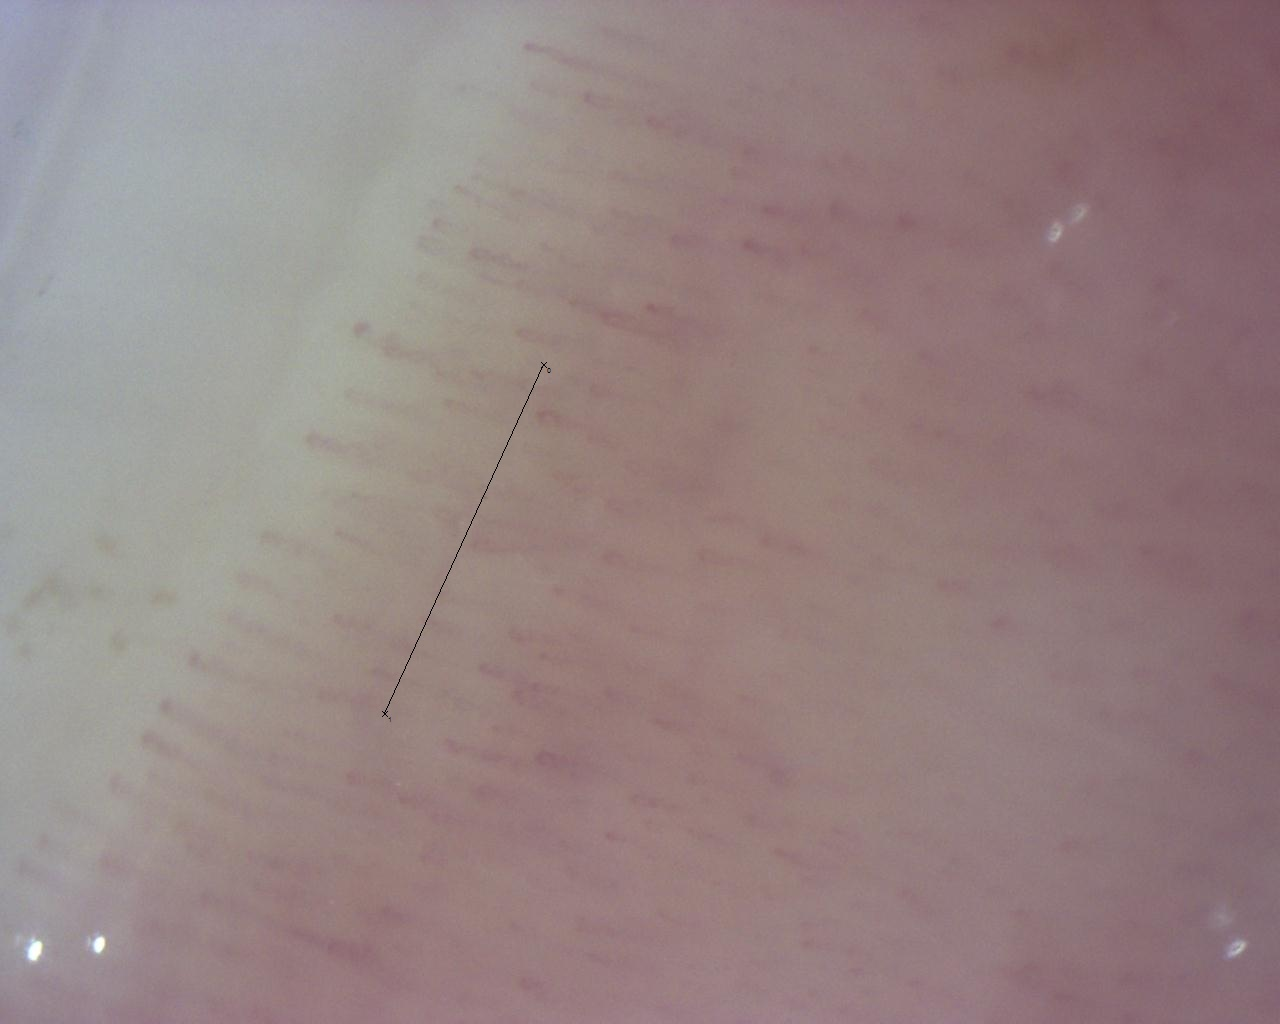

Predicted Mask:


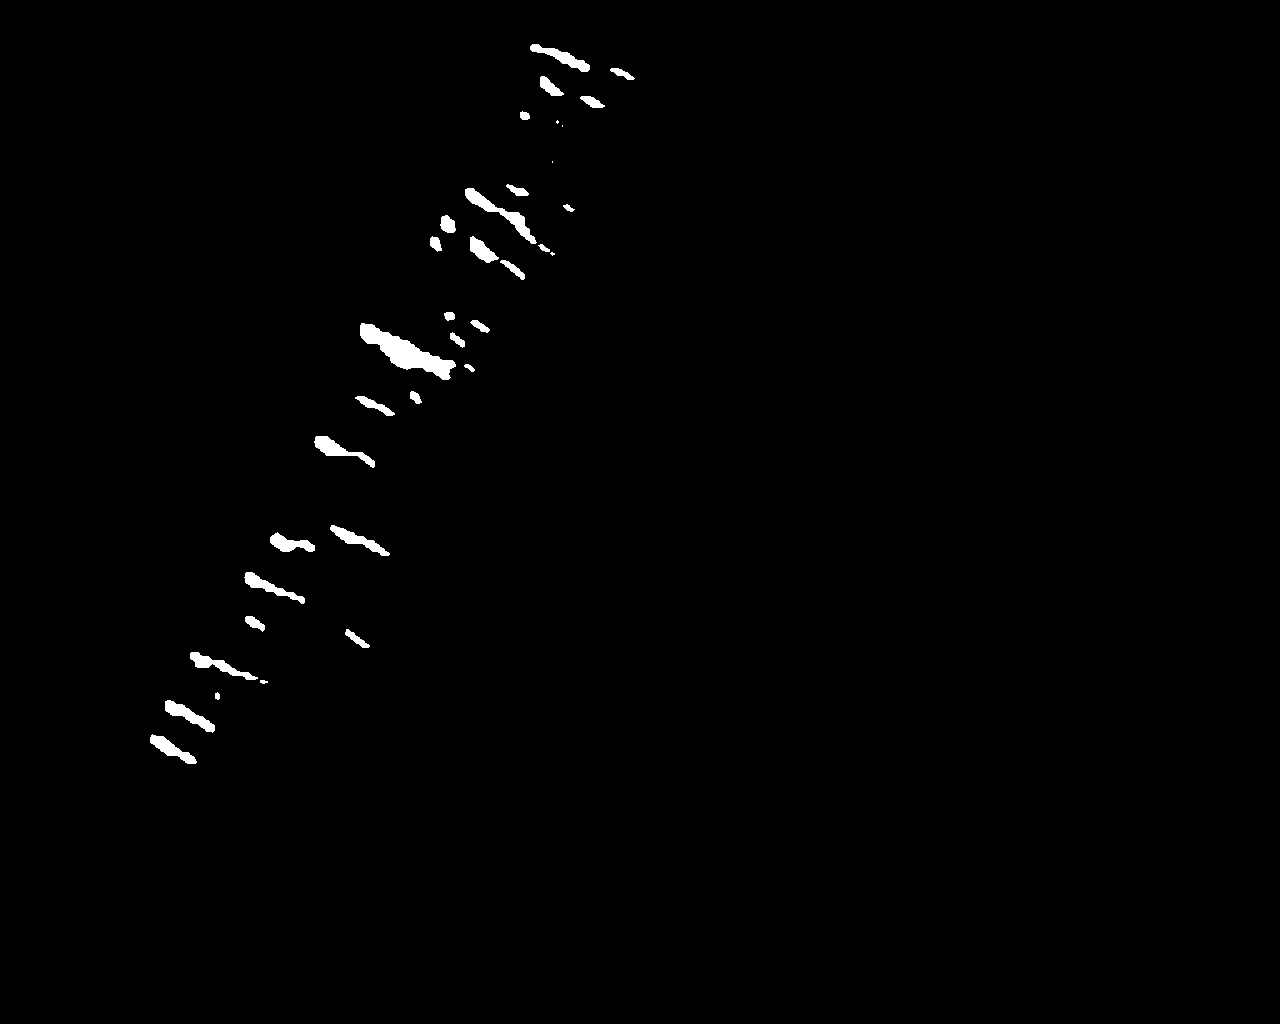

Masked Image:


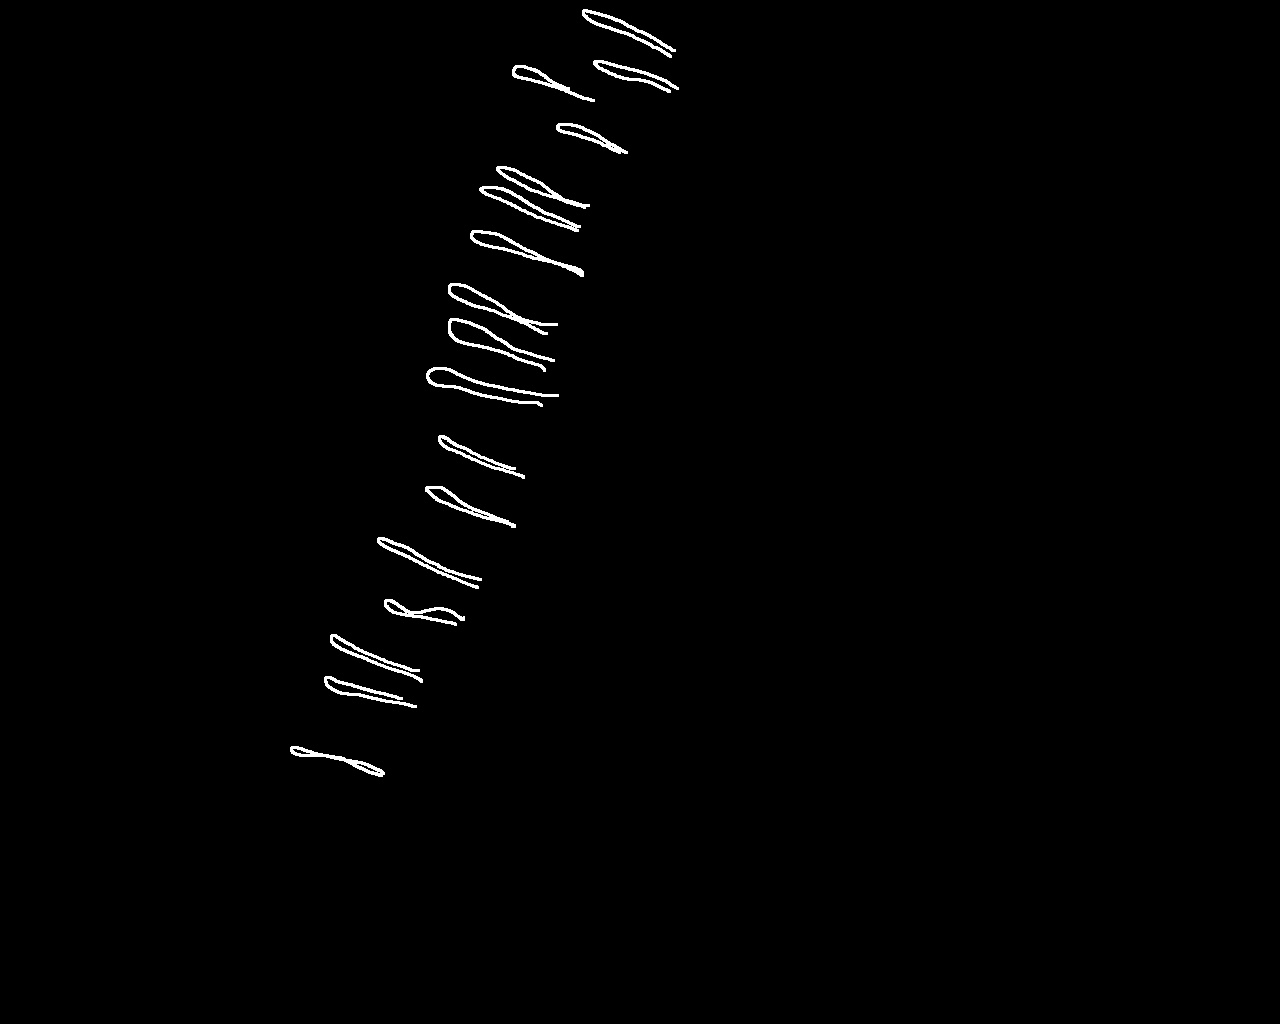

In [10]:
from IPython.display import Image

# Path to the saved images
original_image_path = "/kaggle/working/original_image.jpg"
predicted_mask_path = "/kaggle/working/predicted_mask.jpg"
masked_image_path = "/kaggle/input/segmentation/Segmentation Dataset/seg_masks/N26gmask.jpg"

# Display the original image
print("Original Image:")
display(Image(filename=original_image_path))

# Display the predicted mask
print("Predicted Mask:")
display(Image(filename=predicted_mask_path))

# Display the masked image
print("Masked Image:")
display(Image(filename=masked_image_path))

In [11]:
input_shape = (256, 256, 3)

def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = tf.keras.models.Model(inputs, outputs, name="UNET")
    return model


model = build_unet(input_shape)
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 256, 256, 64) 256         conv2d_42[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 256, 256, 64) 0           batch_normalization_36[0][0]     
_______________________________________________________________________________________________

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [12]:
model = build_unet((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=False),
]

history3=model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/300
4/4 [==============================] - 9s 2s/step - loss: 0.9785 - dice_coef: 0.0195 - val_loss: 0.9796 - val_dice_coef: 0.0211

Epoch 00001: val_loss improved from inf to 0.97958, saving model to files/model.h5
Epoch 2/300
4/4 [==============================] - 6s 2s/step - loss: 0.9726 - dice_coef: 0.0258 - val_loss: 0.9796 - val_dice_coef: 0.0211

Epoch 00002: val_loss improved from 0.97958 to 0.97957, saving model to files/model.h5
Epoch 3/300
4/4 [==============================] - 6s 2s/step - loss: 0.9686 - dice_coef: 0.0305 - val_loss: 0.9796 - val_dice_coef: 0.0211

Epoch 00003: val_loss did not improve from 0.97957
Epoch 4/300
4/4 [==============================] - 6s 1s/step - loss: 0.9640 - dice_coef: 0.0353 - val_loss: 0.9796 - val_dice_coef: 0.0211

Epoch 00004: val_loss did not improve from 0.97957
Epoch 5/300
4/4 [==============================] - 6s 2s/step - loss: 0.9572 - dice_coef: 0.0417 - val_loss: 0.9796 - val_dice_coef: 0.0211

Epoch 00005: val_loss d

In [34]:
import cv2
import numpy as np

def predict_mask(model, image_path):
    # Read and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256)) / 255.0
    img = np.expand_dims(img, axis=0)

    # Perform prediction
    mask = model.predict(img)

    return mask.squeeze()

def save_images(image_path, mask, output_dir="/kaggle/working/"):
    # Read the original image
    img = cv2.imread(image_path)

    # Resize mask to match original image size
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

    # Threshold the mask
    mask = (mask > 0.5).astype(np.uint8) * 255

    # Apply the mask to the original image
    masked_img = cv2.bitwise_and(img, img, mask=mask)

    # Save images
    cv2.imwrite(f"{output_dir}/original_image.jpg", img)
    cv2.imwrite(f"{output_dir}/predicted_mask.jpg", mask)
    cv2.imwrite(f"{output_dir}/masked_image.jpg", masked_img)

# Load the trained model
model = tf.keras.models.load_model(model_path, compile=False)

# Path to a test image
test_image_path = test_x[4]  # You can replace this with any test image path
test_mask_path = test_y[4]
# Predict mask for the test image
predicted_mask = predict_mask(model, test_image_path)

# Save and view the images
save_images(test_image_path, predicted_mask)


In [35]:
test_mask_path = test_y[4]
print(test_mask_path)

/kaggle/input/segmentation/Segmentation Dataset/seg_masks/N32bmask.jpg


Original Image:


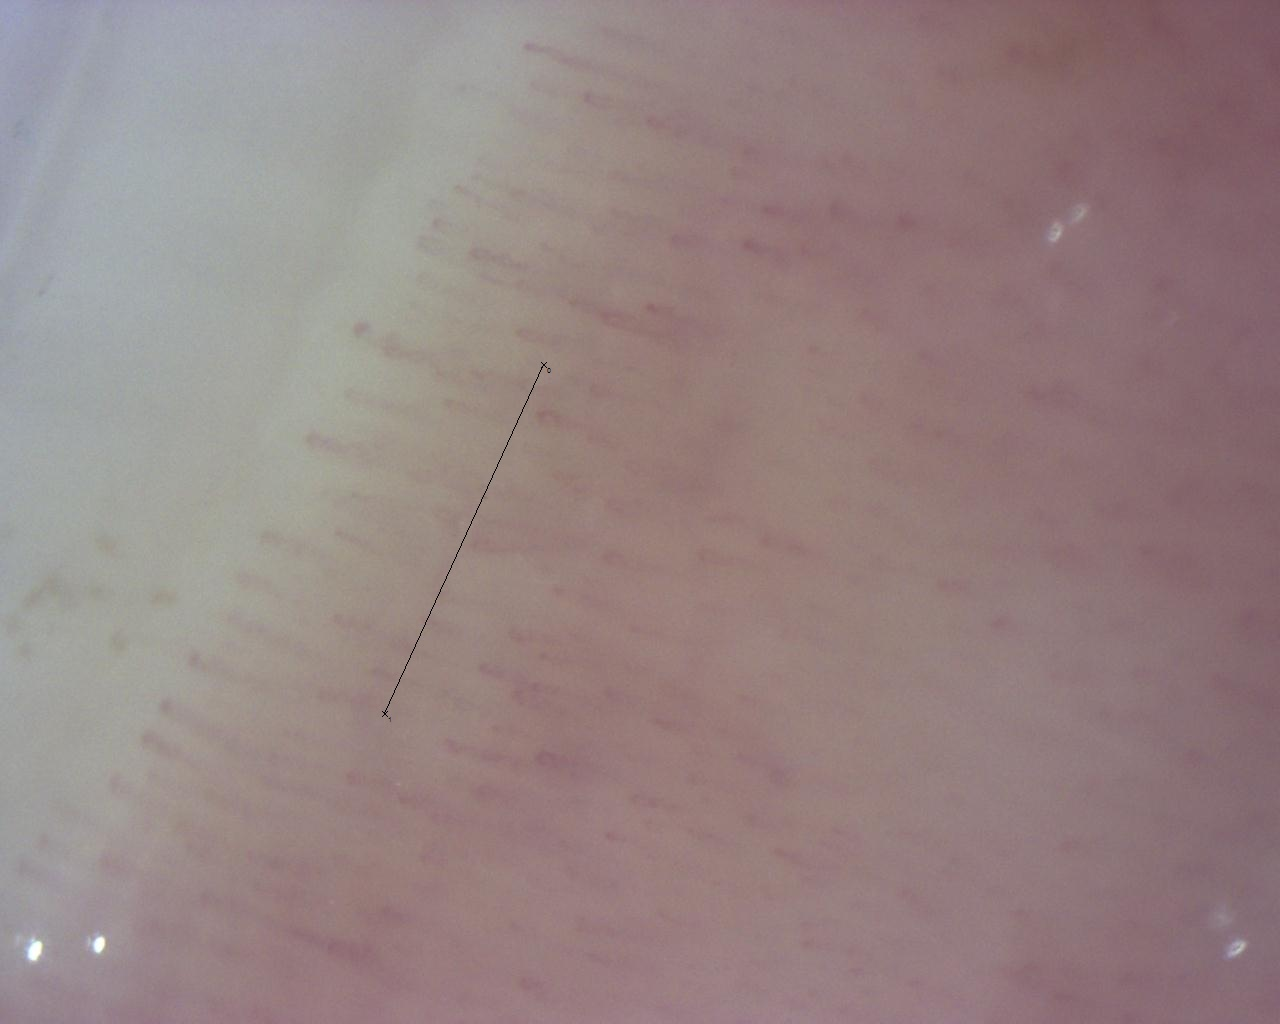

Predicted Mask:


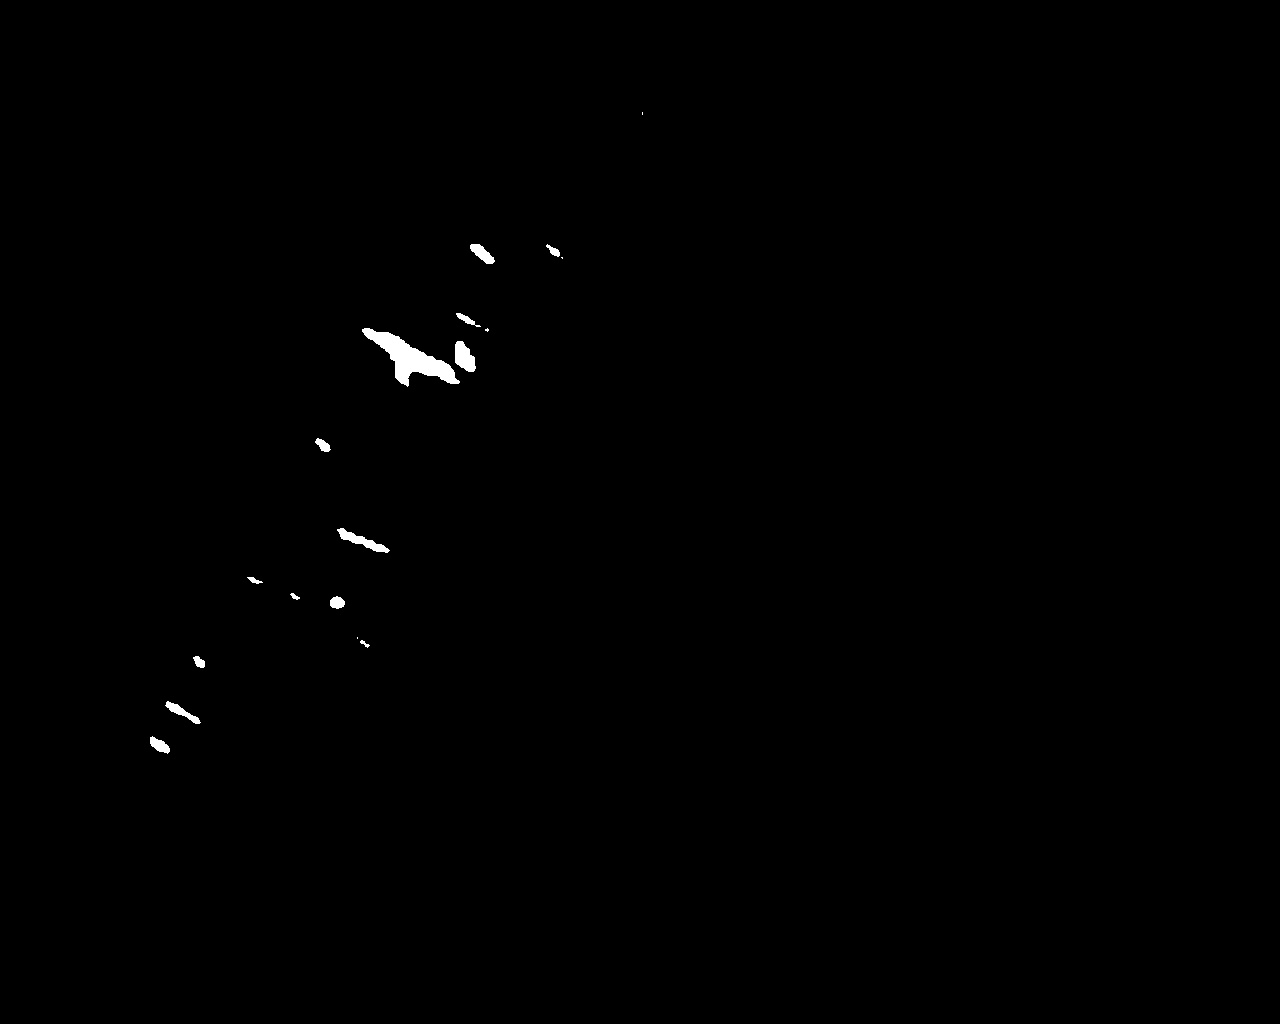

Masked Image:


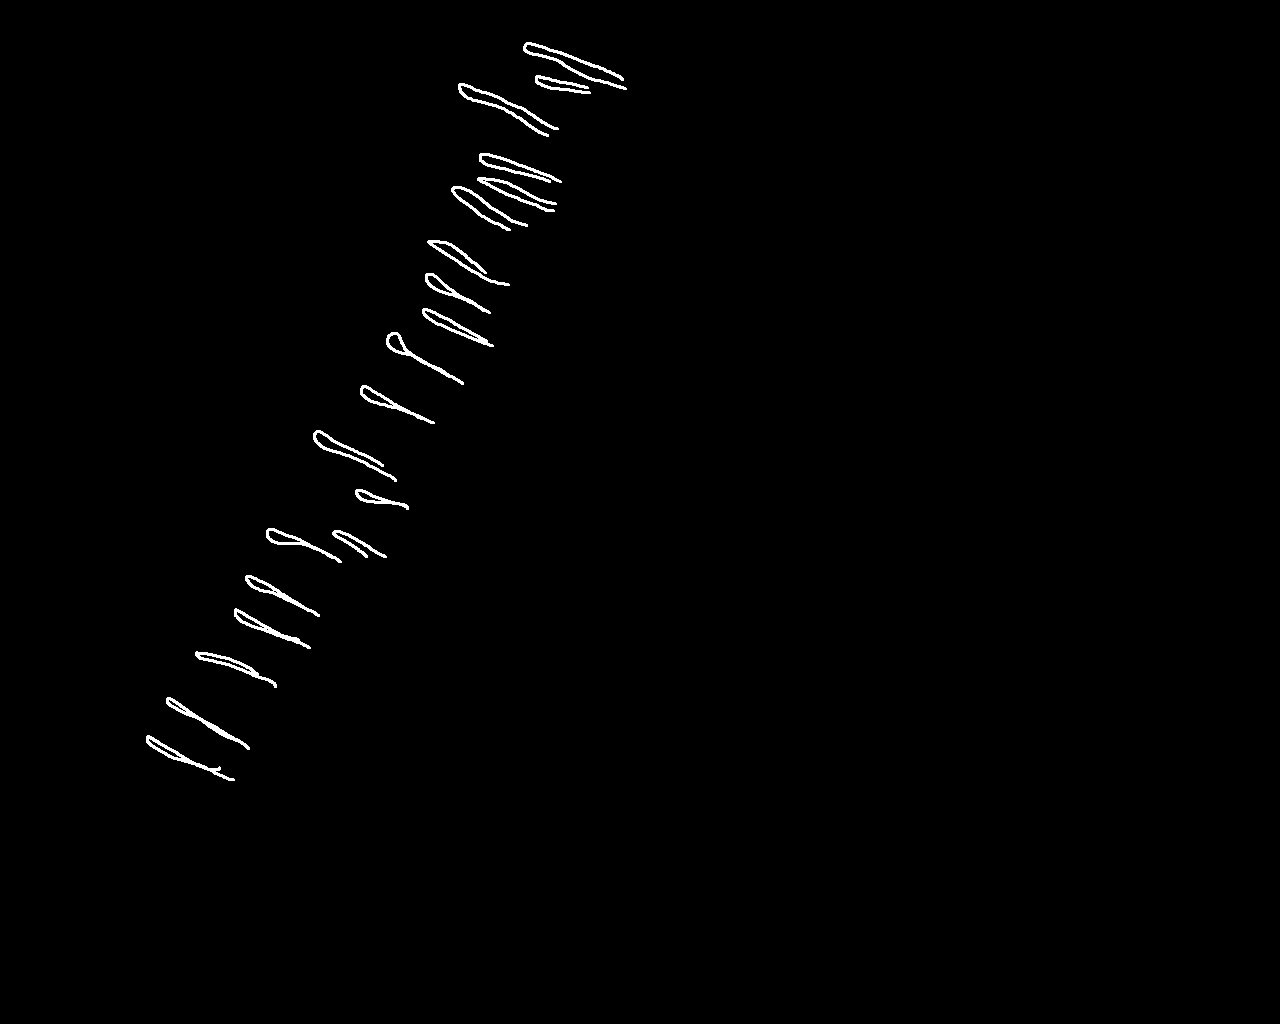

In [36]:
from IPython.display import Image

# Path to the saved images
original_image_path = "/kaggle/working/original_image.jpg"
predicted_mask_path = "/kaggle/working/predicted_mask.jpg"
masked_image_path = "/kaggle/input/segmentation/Segmentation Dataset/seg_masks/N32bmask.jpg"

# Display the original image
print("Original Image:")
display(Image(filename=original_image_path))

# Display the predicted mask
print("Predicted Mask:")
display(Image(filename=predicted_mask_path))

# Display the masked image
print("Masked Image:")
display(Image(filename=masked_image_path))
